# Taking GeoGrapher for a Spin

Let us see how we can use GeoGrapher to a build a toy example dataset of stadiums.
You can download the file `stadiums.geojson` containing the stadiums from ([link](https://github.com/dida-do/GeoGrapher/tree/main/notebooks/stadiums.geojson)).

## 1. Creating an Empty Dataset

First, we import geographer, as well as some other imports we will need.

In [1]:
import geographer as gg
import geopandas as gpd
from pathlib import Path

/home/rustam/dida/GeoGrapher/geographer-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The GeoGrapher library is built around the `Connector` class. A connector organizes a dataset of raster and vector data keeping track of the containment and intersection relations between raster and vector features. To create an empty dataset, we use the `from_scratch` factory method:

In [3]:
from geographer import Connector

DATA_DIR = Path("gg_example_dataset_blogpost")

connector = Connector.from_scratch(
    data_dir=DATA_DIR,
    task_vector_classes=["stadium"],
)

This creates a connector with a dataset in `DATA_DIR`.

The most important attributes of a connector are its `vectors` and `rasters` attributes. The `vectors` GeoDataFrame contains the vector geometries of the stadiums as well as tabular information about the stadiums (name, country, etc). The `rasters` GeoDataFrame contains as geometries the bounding boxes of the rasters in our dataset as well as tabular information about the rasters (e.g. raster name, date, etc). Of course, both GeoDataFrames are still empty. Let us change that. 

Let's try adding our stadiums to the `vectors`. You can find the example geojson file in [https://github.com/dida-do/GeoGrapher/blob/main/notebooks/stadiums_binary.geojson](https://github.com/dida-do/GeoGrapher/blob/main/notebooks/stadiums_binary.geojson).

In [4]:
stadiums = gpd.read_file("stadiums_binary.geojson")
stadiums = stadiums.set_index("vector_name")
stadiums

,location,type,geometry
vector_name,,,
Munich Olympiastadion,"Munich, Germany",stadium,"POLYGON Z ((11.54677 48.17472 0.00000, 11.5446..."
Munich Track and Field Stadium1,"Munich, Germany",stadium,"POLYGON Z ((11.54382 48.17279 0.00000, 11.5438..."
Munich Olympia Track and Field2,"Munich, Germany",stadium,"POLYGON Z ((11.54686 48.17892 0.00000, 11.5468..."
Munich Staedtisches Stadion Dantestr,"Munich, Germany",stadium,"POLYGON Z ((11.52913 48.16874 0.00000, 11.5291..."
Vasil Levski National Stadium,"Sofia, Bulgaria",stadium,"POLYGON Z ((23.33410 42.68813 0.00000, 23.3340..."
Bulgarian Army Stadium,"Sofia, Bulgaria",stadium,"POLYGON Z ((23.34065 42.68492 0.00000, 23.3406..."
Arena Sofia,"Sofia, Bulgaria",stadium,"POLYGON Z ((23.34018 42.68318 0.00000, 23.3401..."
Jingu Baseball Stadium,"Tokyo, Japan",stadium,"POLYGON Z ((139.71597 35.67490 0.00000, 139.71..."
Japan National Stadium,"Tokyo, Japan",stadium,"POLYGON Z ((139.71482 35.67644 0.00000, 139.71..."


Now, we can integrate the vector features into the dataset, i.e. into the connector:

In [5]:
connector.add_to_vectors(stadiums)

We see that the stadiums have been added to the connector:

In [6]:
connector.vectors

,geometry,raster_count,location,type
vector_name,,,,
Munich Olympiastadion,"POLYGON Z ((11.54677 48.17472 0.00000, 11.5446...",0,"Munich, Germany",stadium
Munich Track and Field Stadium1,"POLYGON Z ((11.54382 48.17279 0.00000, 11.5438...",0,"Munich, Germany",stadium
Munich Olympia Track and Field2,"POLYGON Z ((11.54686 48.17892 0.00000, 11.5468...",0,"Munich, Germany",stadium
Munich Staedtisches Stadion Dantestr,"POLYGON Z ((11.52913 48.16874 0.00000, 11.5291...",0,"Munich, Germany",stadium
Vasil Levski National Stadium,"POLYGON Z ((23.33410 42.68813 0.00000, 23.3340...",0,"Sofia, Bulgaria",stadium
Bulgarian Army Stadium,"POLYGON Z ((23.34065 42.68492 0.00000, 23.3406...",0,"Sofia, Bulgaria",stadium
Arena Sofia,"POLYGON Z ((23.34018 42.68318 0.00000, 23.3401...",0,"Sofia, Bulgaria",stadium
Jingu Baseball Stadium,"POLYGON Z ((139.71597 35.67490 0.00000, 139.71...",0,"Tokyo, Japan",stadium
Japan National Stadium,"POLYGON Z ((139.71482 35.67644 0.00000, 139.71...",0,"Tokyo, Japan",stadium


# 3. Downloading Rasters for the Vector Data

To download rasters for the stadiums, we define a downloader:

In [7]:
from geographer.downloaders import (
    RasterDownloaderForVectors,
    SentinelDownloaderForSingleVector,
    Sentinel2Processor,
)

downloader_for_single_vector = SentinelDownloaderForSingleVector()
download_processor = Sentinel2Processor()

downloader = RasterDownloaderForVectors(
    downloader_for_single_vector=downloader_for_single_vector,
    download_processor=download_processor,
)

To use the Copernicus SciHub API we need to a username and password. You can sign up for an account [here](https://scihub.copernicus.eu/dhus/#/self-registration). The password and username will be assumed to be stored in a .ini file.

In [8]:
credentials_ini_path = Path("copernicus_scihub_credentials.ini")

The contents of the ini file should look as follows:

```
[login]
username = your_username
password = your_password
```

To download rasters and add them to our dataset we then run the following command.

In [ ]:
downloader.download(
    connector=connector,
    credentials=credentials_ini_path,  # could also directly supply (username, password) tuple
    producttype="L2A",
    max_percent_cloud_coverage=10,
    resolution=10,  # resolution of extracted GeoTiff
    date=("NOW-364DAYS", "NOW"),
    area_relation="Contains",
)

 The `rasters` attribute now contains information about the rasters:

In [15]:
connector.rasters

,raster_processed?,timestamp,orig_crs_epsg_code,geometry
raster_name,,,,
S2A_MSIL2A_20220627T100611_N0400_R022_T32UPU_20220627T162810.tif,True,2022-06-27-10:06:11,32632,"POLYGON ((11.79809 47.73104, 11.85244 48.71769..."
S2A_MSIL2A_20220412T012701_N0400_R074_T54SUE_20220412T042315.tif,True,2022-04-12-01:27:01,32654,"POLYGON ((140.00972 35.15084, 139.99743 36.140..."
S2A_MSIL2A_20220722T092041_N0400_R093_T34TFN_20220722T134859.tif,True,2022-07-22-09:20:41,32634,"POLYGON ((23.54663 42.33578, 23.58754 43.32358..."


The connector keeps track of the containment and intersection relations between vector features and rasters in the form of an internal bipartite graph. We can ask questions about this graph, such as which rasters contain (or intersect) a given vector feature (stadium):

In [16]:
# rasters containing a vector feature
vector_name = "Munich Olympiastadion"
containing_rasters = connector.rasters_containing_vector(vector_name)
print(f"rasters containing {vector_name}:\n{containing_rasters} \n")

# vector features intersecting a raster
raster_name = containing_rasters[0]
intersecting_vectors = connector.vectors_intersecting_raster(raster_name)
print(f"vector features (stadiums) intersecting {raster_name}:\n{intersecting_vectors}")

rasters containing Munich Olympiastadion:
['S2A_MSIL2A_20220627T100611_N0400_R022_T32UPU_20220627T162810.tif'] 

vector features (stadiums) intersecting S2A_MSIL2A_20220627T100611_N0400_R022_T32UPU_20220627T162810.tif:
['Munich Track and Field Stadium1', 'Munich Olympiastadion', 'Munich Olympia Track and Field2', 'Munich Staedtisches Stadion Dantestr']


We can now create a dataset of cutouts around each stadium.

In [12]:
from geographer.cutters import get_cutter_rasters_around_every_vector

IMG_SIZE = 512
TARGET_DATA_DIR = Path(f"gg_example_dataset_blogpost_cutouts{IMG_SIZE}")

cutter = get_cutter_rasters_around_every_vector(
    source_data_dir=DATA_DIR,
    target_data_dir=TARGET_DATA_DIR,
    name="example_cutter",  # for saving
    new_raster_size=IMG_SIZE,  # in pixels
    bands={"rasters": [1, 2, 3]},  # we only want the RGB (or BGR for Sentinel-2) bands
)
target_connector = cutter.cut()

Cutting dataset: 100%|██████████| 9/9 [00:01<00:00,  7.56it/s]


And finally, we can create segmentation labels (masks) for our new dataset:

In [13]:
from geographer.label_makers import SegLabelMakerCategorical

label_maker = SegLabelMakerCategorical()
label_maker.make_labels(connector=target_connector)

Making labels: 100%|██████████| 3/3 [00:00<00:00, 39.25it/s]


We can now take a look at one of our rasters and the segmentation label/mask:

(-0.5, 511.5, 511.5, -0.5)

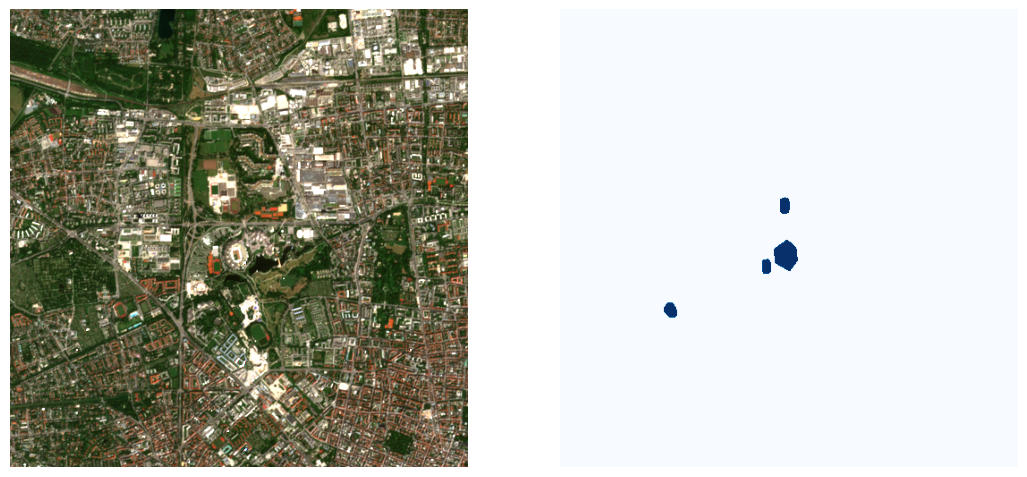

In [18]:
import rioxarray
from matplotlib import pyplot as plt

raster_paths = target_connector.rasters_containing_vector("Munich Olympiastadion", mode="paths")
raster_path = raster_paths[0]
label_path = target_connector.labels_dir / raster_path.name

raster = rioxarray.open_rasterio(raster_path).sel(band=[1,2,3]).values.transpose(1, 2, 0) / 65535
label = rioxarray.open_rasterio(label_path).values.transpose(1, 2, 0) / 255

fig, ax = plt.subplots(1,2, figsize=(13, 13))

ax[0].imshow(raster)
ax[0].axis("off")

ax[1].imshow(label, cmap="Blues")
ax[1].axis("off")